In [1]:
import os, random, math

from tqdm import tqdm
from PIL import Image, ImageEnhance, ImageOps
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split

from FingerNetV3.model import FingerNetV3
from FingerNetV3.dataset import RidgeValleyDataset
from FingerNetV3.loss import compute_multitask_loss, total_loss_from_dict
from FingerNetV3.display import draw_minutiae_comparison, draw_segmentation_comparison, label2mnt, nms_minutiae

In [2]:
root_dir = '../../datasets/fingerprints/original/'
images_dir = root_dir + 'images'
templates_dir = root_dir + 'templates'
masks_dir = root_dir + 'segmasks'

# Get all candidate image files (filenames only, not paths)
all_image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.bmp', '.png', '.jpg', '.tif', '.wsq'))]
all_image_files.sort()

# Filter for files that exist in all 3 locations
valid_files = []
for f in all_image_files:
    tmpl = os.path.splitext(f)[0] + '.incits378'
    if (
        os.path.exists(os.path.join(templates_dir, tmpl)) and
        os.path.exists(os.path.join(masks_dir, f))
    ):
        valid_files.append(f)

print(f"Found {len(valid_files)} valid files.")

# Split
train_files, val_files = train_test_split(valid_files, test_size=0.15, random_state=42)
print(len(train_files), len(val_files))

Found 30191 valid files.
25662 4529


In [ ]:
train_set = RidgeValleyDataset(images_dir, templates_dir, masks_dir, train_files, augment=True)
val_set = RidgeValleyDataset(images_dir, templates_dir, masks_dir, val_files)

train_loader = DataLoader(train_set, batch_size=3, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=2, shuffle=False, num_workers=4, pin_memory=True)

seg_pred contains NaNs: False


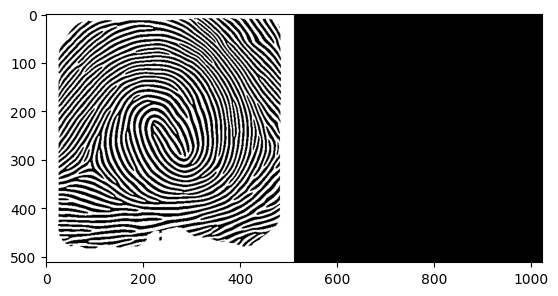

In [ ]:
import matplotlib.pyplot as plt

# test display!
model = FingerNetV3().to('cpu')
model.eval()

for i in range(1):
    x, y = train_set.__getitem__(i)
    output = model(x.unsqueeze(0))
    mnt_gt = label2mnt(
        y['mnt_s_out'].cpu().numpy(),
        y['mnt_w_out'].cpu().numpy(),
        y['mnt_h_out'].cpu().numpy(),
        y['mnt_o_out'].cpu().numpy()
    )

    mnt_pred = label2mnt(
        output['minutiae']['mnt_s_score'].detach().cpu().numpy(),
        output['minutiae']['mnt_w_score'].detach().cpu().numpy(),
        output['minutiae']['mnt_h_score'].detach().cpu().numpy(),
        output['minutiae']['mnt_o_score'].detach().cpu().numpy()
    )

    print("seg_pred contains NaNs:", torch.isnan(output['segmentation']).any().item())

seg_gt = y['seg_out'].cpu().numpy()[0]
seg_pred = output['segmentation'].detach().cpu().numpy()[0, 0]
seg_vis = draw_segmentation_comparison(seg_gt, seg_pred)
mnt_vis = draw_minutiae_comparison(x.detach().cpu().numpy()[0], mnt_gt, mnt_pred)
# plt.imshow(seg_vis, cmap = 'gray')
plt.imshow(mnt_vis)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Using device:", device),
model = FingerNetV3().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

Using device: cuda


In [6]:
writer = SummaryWriter(log_dir='runs/fingernet-v3')

In [7]:
import time

epochs = 30
log_interval = 150

for epoch in range(1, epochs + 1):
    print(f"\n=== Epoch {epoch}/{epochs} ===")

    # --- Training ---
    model.train()
    total_train_loss = 0
    train_components = {}

    tqdm_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"[Train] Epoch {epoch}/{epochs}")
    for batch_idx, (img, target) in tqdm_bar:
        img = img.to(device)
        target = {k: v.to(device) for k, v in target.items()}

        torch.cuda.synchronize()
        time.sleep(0.15)  # sleep for 200ms

        optimizer.zero_grad()
        output = model(img)
        details = compute_multitask_loss(output, target)
        loss = total_loss_from_dict(details)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        total_train_loss += loss.item()
        for k, v in details.items():
            train_components[k] = train_components.get(k, 0) + v.item()

        tqdm_bar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'Seg': f"{details['seg_loss']:.3f}",
            'S': f"{details['mnt_s_loss']:.4f}",
            'O': f"{details['mnt_o_loss']:.4f}",
            'W': f"{details['mnt_w_loss']:.4f}",
            'H': f"{details['mnt_h_loss']:.4f}"
        })

        if (batch_idx + 1) % log_interval == 0:
            # Scalars
            global_step = epoch * len(train_loader) + batch_idx

            # 
            writer.add_scalar("train/total", loss.item(), global_step)
            writer.add_scalar("train/seg_loss", details["seg_loss"], global_step)
            writer.add_scalar("train/mnt_s_loss", details["mnt_s_loss"], global_step)
            writer.add_scalar("train/mnt_o_loss", details["mnt_o_loss"], global_step)
            writer.add_scalar("train/mnt_w_loss", details["mnt_w_loss"], global_step)
            writer.add_scalar("train/mnt_h_loss", details["mnt_h_loss"], global_step)

            img = img.cpu().numpy()[0]
            seg_gt = target['seg_out'].cpu().numpy()[0, 0]
            seg_pred = output['segmentation'].detach().cpu().numpy()[0, 0]
            seg_vis = draw_segmentation_comparison(seg_gt, seg_pred)

            mnt_gt = label2mnt(
                target['mnt_s_out'].cpu().numpy()[0],
                target['mnt_w_out'].cpu().numpy()[0],
                target['mnt_h_out'].cpu().numpy()[0],
                target['mnt_o_out'].cpu().numpy()[0]
            )

            mnt_pred = label2mnt(
                output['minutiae']['mnt_s_score'].detach().cpu().numpy()[0],
                output['minutiae']['mnt_w_score'].detach().cpu().numpy()[0],
                output['minutiae']['mnt_h_score'].detach().cpu().numpy()[0],
                output['minutiae']['mnt_o_score'].detach().cpu().numpy()[0]
            )


            mnt_pred = nms_minutiae(mnt_pred)
            mnt_vis = draw_minutiae_comparison(img, mnt_gt, mnt_pred)

            # BGR -> RGB for TensorBoard
            seg_vis = cv2.cvtColor(seg_vis, cv2.COLOR_BGR2RGB)
            mnt_vis = cv2.cvtColor(mnt_vis, cv2.COLOR_BGR2RGB)

            writer.add_image("segmentation", torch.from_numpy(seg_vis).permute(2, 0, 1), global_step)
            writer.add_image("minutiae", torch.from_numpy(mnt_vis).permute(2, 0, 1), global_step)

    n_train = len(train_loader)
    avg_train_loss = total_train_loss / n_train
    print(f"Train Loss: {avg_train_loss:.4f}")
    for k, v in train_components.items():
        print(f" - {k}: {v / n_train:.4f}")
        writer.add_scalar(f"train/{k}", v / n_train, epoch)
    writer.add_scalar("train/total", avg_train_loss, epoch)

    tqdm_bar.set_postfix({
        'Loss': f"{avg_train_loss:.4f}",
        'Seg': f"{details['seg_loss']:.3f}",
        'S': f"{details['mnt_s_loss']:.4f}",
        'O': f"{details['mnt_o_loss']:.4f}",
        'W': f"{details['mnt_w_loss']:.4f}",
        'H': f"{details['mnt_h_loss']:.4f}"
    })

    # --- Validation ---
    model.eval()
    total_val_loss = 0
    val_components = {}

    with torch.no_grad():
        for img, target in tqdm(val_loader, desc="Validation", leave=False):
            img = img.to(device)
            target = {k: v.to(device) for k, v in target.items()}
            output = model(img)

            torch.cuda.synchronize()
            time.sleep(0.12)  # sleep for 120ms

            details = compute_multitask_loss(output, target)

            total_val_loss += total_loss_from_dict(details)
            for k, v in details.items():
                val_components[k] = val_components.get(k, 0) + v.item()

        n_val = len(val_loader)
        avg_val_loss = total_val_loss / n_val
        print(f"Val Loss: {avg_val_loss:.4f}")
        for k, v in val_components.items():
            print(f" - {k}: {v / n_val:.4f}")
            writer.add_scalar(f"val/{k}", v / n_val, epoch)
        writer.add_scalar("val/total", avg_val_loss, epoch)


=== Epoch 1/30 ===


[Train] Epoch 1/30:   0%|          | 24/8554 [00:10<1:01:47,  2.30it/s, Loss=62.1973, Seg=1.084, S=0.0114, O=94.9446, W=4.5481, H=4.9270] 


KeyboardInterrupt: 